# Generative Adversarial Networks for X-RAY Classification

The [MedMNIST v2 dataset](https://medmnist.com/) is the MNIST of Medical Imaging containing a large-scale MNIST-like collection of standardized biomedical images.

Can we use this dataset to generate additional synthetic images? Can we condition the data generation on a label? 

Let's try this in this exercise!

## Exercise:


#### 1. Definition of Research Question
We propose to explore one of the MedMNIST datasets and and define a suitable research question. This research question should contain GANs in its hypothesis and aiming towards solving a useful clinical task. Note: Normally, one would also look up the literature to see if the research question is already answered. For now, we skip this step

#### 2. Definition of a Baseline for the Research Question
To test our hypothesis, we need to gather experimental data to compare our solution against the state-of-the-art. The state-of-the-art is our baseline method.

#### 3. Implementation of the Baseline
We implement the baseline and try to do so making our code reusable for our method  (e.g. dataloaders, downstream classifer).  

#### 4. Testing the Baseline and Storage of Results
Now, we test out our baseline implementation and gather the corresponding empirical results and observe its results on our target performance metrics. Can these results be improved upon? Or, can similar results be aachieved with our more e.g. privacy-preserving, interpretable, generalizable, simpler, or more environment friendly solution?

#### 5. Implementation of our GAN Method
The method we hypothesise for the clinical task at hand would need to be implemented to allow testing its usefulness. 

#### 6. Test of our GAN Method and Storage of Results
Now is the time to observe whether our method/intervention yields useful results, as we can readily compare it to our  baseline. 

#### 7. Comparison of our Method and Baseline, Interpretration of Results
Now that we have generated some experimental data, we can interpret our results and clearly demonstrate whether our method was useful for the clinical task. We can now reject or accept our hypothesis.

#### 8. Reflective Account
What could be the reasons why our study did or did not succeed? What do you think are the limitations of our study? What can we learn and takeaway from this exercise? How should it inform our future work? What are the next things to try?

# 1. Definition of a Research question


### Review of MedMNIST Datasets

The MedMNIST dataset including 12 datasets for 2D and 6 datasets for 3D, in total containing 708,069 2D images and 10,214 3D images. The dataset is pre-processed into 28 x 28 (2D) or 28 x 28 x 28 (3D) images alongside the corresponding classification labels for diverse classification tasks (binary/multi-class, ordinal regression and multi-label). More information can be found in the [MedMNIST homepage](https://medmnist.com/).


### Choice of PneumoniaMNIST Dataset for our Study

We propose to use the PneumoniaMNIST dataset from MedMNIST, which contains to 5,856 chest x-rays (train: 4,708, validation: 524, test: 624). The reason for choosing this dataset is that its respective image classification task is binary (pneumonia/normal). Binary classification is likely to be simpler than multi-class classification for data augmentation purposes i.e. only two rather than multiple class-conditioned images need to be generated.
More information on the source of the Pneumonia dataset can be found [here](https://www.sciencedirect.com/science/article/pii/S0092867418301545).


### Definition of our Research Question

We follow the clinical task defined by the dataset providers, which is the classification of resampled chest xrays to diagnose lung pneumonia.

In this regard, our objective would be to maximize the performance of the classifier on the test dataset that should, in theory, resemble the real world distribution if we'd deploy our classifer into a clinical setting. 

Now, we could train a GAN to augment the classfier's training data, which might improve classification performance.

However, the [reported performance](https://medmnist.com/) is already quite strong: 

**ResNet-18: AUC: 0.944, ACC: 0.854**

There seems to be not that much to gain with GAN-based data augmentation (*Note: You may still try if you like*). 

On the other hand, privacy preservation is a topic of immense importance in medical imaging. The pneumonia chest scans are from a pediatric patient cohort that paticularly requires special data protection. We could train a GAN to generate a synthetic dataset that would likely need less privacy protection than the real data. 

*Note: Feel free to checkout the related topic of [differential privacy](https://ai.googleblog.com/2022/02/applying-differential-privacy-to-large.html) that provides a guarantee of privacy, among others, in neural networks.*

In this sense, we can now define our hypothesis:

**H1: Could we, instead of using real patient data, use only synthetic data to train our classifier and achieve comparable performance?**

# 2. Definition of a Baseline for the Research Question


##### We can now define our baseline metrics: 
For example, a ResNet-18 trained on the real training dataset achieved AUC: 0.944 and ACC: 0.854 

##### We define our method: 
A simple CNN trained on a GAN-generated synthetic training dataset.

You are free to change the CNN model and use another architecture (e.g.,[see baseline](https://medmnist.com/))

##### How do we create the GAN-generated dataset?
Feel free to explore any idea you have. You may try out different (un)conditional GAN architectures and loss functions. Further below you will find some optional guidance.

# 3. Implementation of the Baseline

### Getting the Data
As always, you need access to the dataset. In this case you can download the pneumoniamnist.npz from [Zenodo](https://zenodo.org/record/5208230#.YmcLxtNBz0o). However, note that you can also access medMNIST data via the python packaging index ([pip](https://pypi.org/project/medmnist/)) or [Github](https://github.com/MedMNIST/MedMNIST) directly as pytorch dataset class.

For example:

In [1]:
!pip3 install medmnist

In [2]:
import medmnist
from medmnist import INFO, Evaluator
info = INFO['pneumoniamnist']
DataClass = getattr(medmnist, info['python_class'])

task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

Let's further explore the dataset. We can start by printing dataset info and checking the label distribution.

In [3]:
# Download the dataset
train_dataset = DataClass(split='train', download=True)

# Print dataset information
print(train_dataset)

Using downloaded and verified file: /Users/davidrosado/.medmnist/pneumoniamnist.npz
Dataset PneumoniaMNIST (pneumoniamnist)
    Number of datapoints: 4708
    Root location: /Users/davidrosado/.medmnist
    Split: train
    Task: binary-class
    Number of channels: 1
    Meaning of labels: {'0': 'normal', '1': 'pneumonia'}
    Number of samples: {'train': 4708, 'val': 524, 'test': 624}
    Description: The PneumoniaMNIST is based on a prior dataset of 5,856 pediatric chest X-Ray images. The task is binary-class classification of pneumonia against normal. We split the source training set with a ratio of 9:1 into training and validation set and use its source validation set as the test set. The source images are gray-scale, and their sizes are (384−2,916)×(127−2,713). We center-crop the images and resize them into 1×28×28.
    License: CC BY 4.0


In [4]:
from collections import Counter

# Check the training label distribution
train_classes = [float(label) for _, label in train_dataset]
print (dict(Counter(train_classes)))

{1.0: 3494, 0.0: 1214}


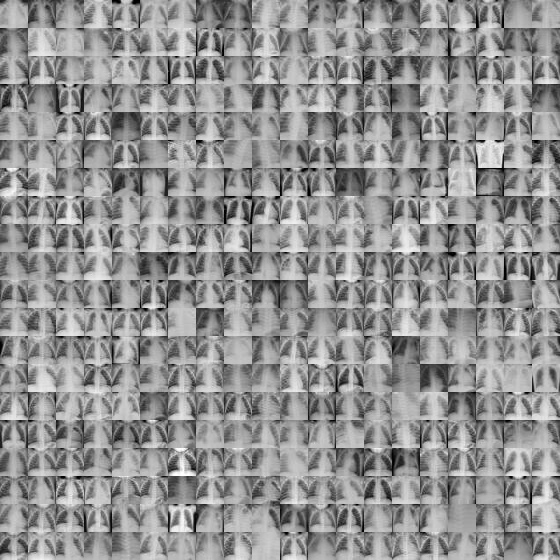

In [5]:
# Let's have a look at some of the training images.
train_dataset.montage(length=20)

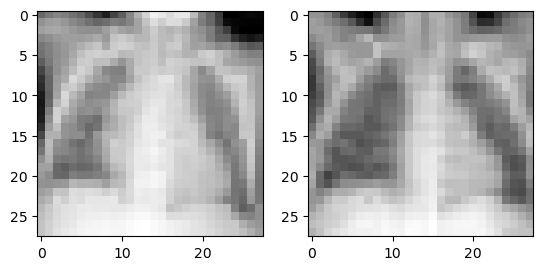

In [6]:
# Let's visually compare pneumial vs. healthy thoraic xray
# 0: normal, 1: pneumonia
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,2)
ax[0].imshow(train_dataset[0][0], cmap='gray') # pneumonia
ax[1].imshow(train_dataset[200][0],cmap='gray') # normal

### Baseline Model Implementation
To implement the baseline, we start with the [medMNIST github](https://github.com/MedMNIST/MedMNIST), where we can find a [Pytorch getting started notebook](https://github.com/MedMNIST/MedMNIST/blob/main/examples/getting_started.ipynb).

In [7]:
# We define a simple CNN model for pneumonia classification
from torch import nn

class Net(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(Net, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels, 16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU())

        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.layer3 = nn.Sequential(
            nn.Conv2d(16, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU())
        
        self.layer4 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU())

        self.layer5 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.fc = nn.Sequential(
            nn.Linear(64 * 4 * 4, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes-1)) # -1 if we use binary CLF

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

Initialization of model, criterion and optimizer

In [8]:
from torch import optim

lr = 0.001

model_base = Net(in_channels=n_channels, num_classes=n_classes)
    
# define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
    
optimizer = optim.SGD(model_base.parameters(), lr=lr, momentum=0.9)


# 4. Testing the Baseline and Storage of Results


Defining hyperparameters and splitting of the dataset into test, validation, train.

In [9]:
data_flag = 'pneumoniamnist'
download = True  #  set to False if already loaded

NUM_EPOCHS = 5
BATCH_SIZE = 128
#lr = 0.001

info = INFO[data_flag]
#task = info['task']
#n_channels = info['n_channels']
#n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

In [10]:
from torchvision import transforms, utils
from torch.utils.data import DataLoader, Dataset

# preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

# load the data
train_dataset = DataClass(split='train', transform=data_transform, download=download)
val_dataset = DataClass(split='val', transform=data_transform, download=download)
test_dataset = DataClass(split='test', transform=data_transform, download=download)

# ingest torch datasets data into torch dataloader
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_loader_at_eval = DataLoader(dataset=train_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
val_loader = DataLoader(dataset=val_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)

Using downloaded and verified file: /Users/davidrosado/.medmnist/pneumoniamnist.npz
Using downloaded and verified file: /Users/davidrosado/.medmnist/pneumoniamnist.npz
Using downloaded and verified file: /Users/davidrosado/.medmnist/pneumoniamnist.npz


Defining evaluation metrics such as the area under the receiver operating characteristic curve (AUROC) and the accuracy (ACC).

In [11]:
def getAUC(y_true, y_score, task):
    '''AUC metric.
    :param y_true: the ground truth labels, shape: (n_samples, n_labels) or (n_samples,) if n_labels==1
    :param y_score: the predicted score of each class,
    shape: (n_samples, n_labels) or (n_samples, n_classes) or (n_samples,) if n_labels==1 or n_classes==1
    :param task: the task of current dataset
    '''
    y_true = y_true.squeeze()
    y_score = y_score.squeeze()

    if task == 'multi-label, binary-class':
        auc = 0
        for i in range(y_score.shape[1]):
            label_auc = roc_auc_score(y_true[:, i], y_score[:, i])
            auc += label_auc
        ret = auc / y_score.shape[1]
    elif task == 'binary-class':
        if y_score.ndim == 2:
            y_score = y_score[:, -1]
        else:
            assert y_score.ndim == 1
        ret = roc_auc_score(y_true, y_score)
    else:
        auc = 0
        for i in range(y_score.shape[1]):
            y_true_binary = (y_true == i).astype(float)
            y_score_binary = y_score[:, i]
            auc += roc_auc_score(y_true_binary, y_score_binary)
        ret = auc / y_score.shape[1]

    return ret

def getACC(y_true, y_score, task, threshold=0.5):
    '''Accuracy metric.
    :param y_true: the ground truth labels, shape: (n_samples, n_labels) or (n_samples,) if n_labels==1
    :param y_score: the predicted score of each class,
    shape: (n_samples, n_labels) or (n_samples, n_classes) or (n_samples,) if n_labels==1 or n_classes==1
    :param task: the task of current dataset
    :param threshold: the threshold for multilabel and binary-class tasks
    '''
    y_true = y_true.squeeze()
    y_score = y_score.squeeze()

    if task == 'multi-label, binary-class':
        y_pre = y_score > threshold
        acc = 0
        for label in range(y_true.shape[1]):
            label_acc = accuracy_score(y_true[:, label], y_pre[:, label])
            acc += label_acc
        ret = acc / y_true.shape[1]
    elif task == 'binary-class':
        if y_score.ndim == 2:
            y_score = y_score[:, -1]
        else:
            assert y_score.ndim == 1
        ret = accuracy_score(y_true, y_score > threshold)
    else:
        ret = accuracy_score(y_true, np.argmax(y_score, axis=-1))

    return ret

Training the baseline pneumonia classification model.

In [12]:
from tqdm import tqdm

for epoch in range(NUM_EPOCHS):
    train_correct = 0
    train_total = 0
    test_correct = 0
    test_total = 0
    
    model_base.train()
    for inputs, targets in tqdm(train_loader):
        # forward + backward + optimize
        optimizer.zero_grad()
        outputs = model_base(inputs)
        
        targets = targets.float()
        outputs = outputs.float()

        print(targets.shape)
        print(outputs.shape)
        loss = criterion(outputs, targets)
        
        loss.backward()
        optimizer.step()

  3%|█▏                                          | 1/37 [00:00<00:12,  2.96it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


  8%|███▌                                        | 3/37 [00:00<00:05,  6.32it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


 19%|████████▎                                   | 7/37 [00:00<00:03,  8.93it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


 24%|██████████▋                                 | 9/37 [00:01<00:02,  9.44it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


 35%|███████████████                            | 13/37 [00:01<00:02,  9.86it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


 41%|█████████████████▍                         | 15/37 [00:01<00:02, 10.09it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


 46%|███████████████████▊                       | 17/37 [00:01<00:01, 10.04it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


 57%|████████████████████████▍                  | 21/37 [00:02<00:01, 10.30it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


 62%|██████████████████████████▋                | 23/37 [00:02<00:01, 10.27it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


 73%|███████████████████████████████▍           | 27/37 [00:02<00:00, 10.37it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


 78%|█████████████████████████████████▋         | 29/37 [00:03<00:00, 10.39it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


 84%|████████████████████████████████████       | 31/37 [00:03<00:00, 10.19it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


 95%|████████████████████████████████████████▋  | 35/37 [00:03<00:00, 10.41it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


100%|███████████████████████████████████████████| 37/37 [00:03<00:00,  9.66it/s]


torch.Size([100, 1])
torch.Size([100, 1])


  3%|█▏                                          | 1/37 [00:00<00:03,  9.57it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


  8%|███▌                                        | 3/37 [00:00<00:03, 10.08it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


 14%|█████▉                                      | 5/37 [00:00<00:03, 10.35it/s]

torch.Size([128, 1])
torch.Size([128, 1])


 19%|████████▎                                   | 7/37 [00:00<00:02, 10.42it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


 24%|██████████▋                                 | 9/37 [00:00<00:02, 10.48it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


 30%|████████████▊                              | 11/37 [00:01<00:02, 10.57it/s]

torch.Size([128, 1])
torch.Size([128, 1])


 35%|███████████████                            | 13/37 [00:01<00:02, 10.54it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


 41%|█████████████████▍                         | 15/37 [00:01<00:02, 10.44it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


 46%|███████████████████▊                       | 17/37 [00:01<00:01, 10.57it/s]

torch.Size([128, 1])
torch.Size([128, 1])


 51%|██████████████████████                     | 19/37 [00:01<00:01, 10.49it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


 57%|████████████████████████▍                  | 21/37 [00:02<00:01, 10.40it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


 62%|██████████████████████████▋                | 23/37 [00:02<00:01, 10.37it/s]

torch.Size([128, 1])
torch.Size([128, 1])


 68%|█████████████████████████████              | 25/37 [00:02<00:01, 10.16it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


 73%|███████████████████████████████▍           | 27/37 [00:02<00:00, 10.19it/s]

torch.Size([128, 1])
torch.Size([128, 1])


 78%|█████████████████████████████████▋         | 29/37 [00:02<00:00, 10.28it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


 84%|████████████████████████████████████       | 31/37 [00:02<00:00, 10.50it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


 89%|██████████████████████████████████████▎    | 33/37 [00:03<00:00, 10.51it/s]

torch.Size([128, 1])
torch.Size([128, 1])


 95%|████████████████████████████████████████▋  | 35/37 [00:03<00:00, 10.46it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([100, 1])
torch.Size([100, 1])


  0%|                                                    | 0/37 [00:00<?, ?it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


  5%|██▍                                         | 2/37 [00:00<00:03, 10.69it/s]

torch.Size([128, 1])
torch.Size([128, 1])


 11%|████▊                                       | 4/37 [00:00<00:03, 10.63it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


 16%|███████▏                                    | 6/37 [00:00<00:02, 10.42it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


 22%|█████████▌                                  | 8/37 [00:00<00:02, 10.37it/s]

torch.Size([128, 1])
torch.Size([128, 1])


 27%|███████████▌                               | 10/37 [00:00<00:02, 10.23it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


 32%|█████████████▉                             | 12/37 [00:01<00:02, 10.24it/s]

torch.Size([128, 1])
torch.Size([128, 1])


 38%|████████████████▎                          | 14/37 [00:01<00:02,  9.94it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


 49%|████████████████████▉                      | 18/37 [00:01<00:01,  9.90it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


 54%|███████████████████████▏                   | 20/37 [00:01<00:01,  9.98it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


 62%|██████████████████████████▋                | 23/37 [00:02<00:01, 10.02it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


 70%|██████████████████████████████▏            | 26/37 [00:02<00:01,  9.93it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


 76%|████████████████████████████████▌          | 28/37 [00:02<00:00, 10.06it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


 81%|██████████████████████████████████▊        | 30/37 [00:02<00:00, 10.14it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


 89%|██████████████████████████████████████▎    | 33/37 [00:03<00:00,  9.92it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


 95%|████████████████████████████████████████▋  | 35/37 [00:03<00:00,  9.87it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


100%|███████████████████████████████████████████| 37/37 [00:03<00:00, 10.09it/s]


torch.Size([100, 1])
torch.Size([100, 1])


  0%|                                                    | 0/37 [00:00<?, ?it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


  5%|██▍                                         | 2/37 [00:00<00:03, 10.55it/s]

torch.Size([128, 1])
torch.Size([128, 1])


 11%|████▊                                       | 4/37 [00:00<00:03,  9.99it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


 16%|███████▏                                    | 6/37 [00:00<00:03, 10.16it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


 22%|█████████▌                                  | 8/37 [00:00<00:02, 10.31it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


 27%|███████████▌                               | 10/37 [00:00<00:02, 10.43it/s]

torch.Size([128, 1])
torch.Size([128, 1])


 32%|█████████████▉                             | 12/37 [00:01<00:02, 10.50it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


 38%|████████████████▎                          | 14/37 [00:01<00:02, 10.48it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


 49%|████████████████████▉                      | 18/37 [00:01<00:01, 10.07it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


 54%|███████████████████████▏                   | 20/37 [00:01<00:01, 10.00it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


 59%|█████████████████████████▌                 | 22/37 [00:02<00:01,  9.95it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


 62%|██████████████████████████▋                | 23/37 [00:02<00:01,  9.95it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


 73%|███████████████████████████████▍           | 27/37 [00:02<00:01,  9.74it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


 78%|█████████████████████████████████▋         | 29/37 [00:02<00:00,  9.82it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


 81%|██████████████████████████████████▊        | 30/37 [00:02<00:00,  9.67it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


 86%|█████████████████████████████████████▏     | 32/37 [00:03<00:00,  9.73it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


 97%|█████████████████████████████████████████▊ | 36/37 [00:03<00:00, 10.00it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([100, 1])
torch.Size([100, 1])


  5%|██▍                                         | 2/37 [00:00<00:03,  9.87it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


 11%|████▊                                       | 4/37 [00:00<00:03, 10.25it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


 16%|███████▏                                    | 6/37 [00:00<00:02, 10.45it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


 27%|███████████▌                               | 10/37 [00:00<00:02, 10.18it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


 32%|█████████████▉                             | 12/37 [00:01<00:02, 10.06it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


 38%|████████████████▎                          | 14/37 [00:01<00:02, 10.06it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


 43%|██████████████████▌                        | 16/37 [00:01<00:02,  9.62it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


 51%|██████████████████████                     | 19/37 [00:01<00:01,  9.80it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


 57%|████████████████████████▍                  | 21/37 [00:02<00:01, 10.12it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


 68%|█████████████████████████████              | 25/37 [00:02<00:01, 10.11it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


 73%|███████████████████████████████▍           | 27/37 [00:02<00:00, 10.29it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


 84%|████████████████████████████████████       | 31/37 [00:03<00:00, 10.22it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


 89%|██████████████████████████████████████▎    | 33/37 [00:03<00:00, 10.27it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


100%|███████████████████████████████████████████| 37/37 [00:03<00:00, 10.20it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([100, 1])
torch.Size([100, 1])


Validation and test of the baseline model. This will let us know how good our model when trained on real data. I have modified this function in order to store some values for plotting the confusion matrix and the ROC-AUC curve, which is requiered in Exercise 7.

In [13]:
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import torch

# evaluation
def test(split, model):
    model.eval()
    y_true = torch.tensor([])
    y_score = torch.tensor([])
    
    if split == 'train':
        data_loader = train_loader_at_eval
    elif split == 'val':
        data_loader = val_loader
    else:
        data_loader = test_loader

    with torch.no_grad():
        for inputs, targets in data_loader:
            outputs = model(inputs)

            targets = targets.to(torch.float32)
            outputs = outputs.sigmoid()
            
            y_true = torch.cat((y_true, targets), 0)
            y_score = torch.cat((y_score, outputs), 0)

        y_true = y_true.numpy()
        y_score = y_score.detach().numpy()
        
        evaluator = Evaluator(data_flag, split)
        metrics = evaluator.evaluate(y_score)
        
        acc = getACC(y_true, y_score, task)
        auc = getAUC(y_true, y_score, task)
        
        print('%s  auc: %.3f  acc:%.3f' % (split, auc, acc))
        
        # Compute the confusion matrix
        cm = confusion_matrix(y_true, y_score>0.5)
    
    
        # Values for plotting ROC-AUC curve
        fpr, tpr, thresholds = roc_curve(y_true, y_score)
        
        return acc, auc, y_true, cm, fpr, tpr

        
print('==> Evaluating baseline model ...')
acc_train_baseline, auc_train_baseline, y_true, cm_train_baseline, fpr_train_baseline, tpr_train_baseline = test('train', model_base)
acc_val_baseline, auc_val_baseline, y_true, cm_val_baseline, fpr_val_baseline, tpr_val_baseline = test('val', model_base)
acc_test_baseline, auc_test_baseline, y_true, cm_test_baseline, fpr_test_baseline, tpr_test_baseline = test('test', model_base)

==> Evaluating baseline model ...
train  auc: 0.990  acc:0.957
val  auc: 0.988  acc:0.958
test  auc: 0.944  acc:0.830


# 5 Definition and Implementation of our GAN Method

#### GAN Architecture Choice

You may use any GAN architecture and loss function you deem suitable. 

To give some guidance, you could try a Deep Convolutional GAN ([DCGAN](https://arxiv.org/abs/1511.06434)). A helpful DCGAN implementation tutorial can be found [here](https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html). 

*Note that you will need to adjust the layers of the network to match the dimensions of the input data.*

DCGAN is an unconditional GAN architecture, which means that the data generation process is not controlled by the label information (pneumonia/normal). Hence, you would need to [extend the DCGAN architecture to a (DC)CGAN](https://machinelearningmastery.com/how-to-develop-a-conditional-generative-adversarial-network-from-scratch/) to be able to feed the labels as input into the generator and discriminator. 

An alternative to the class-conditional GAN is to train an unconditional GAN twice - once on data with positive label and once on data with negative label. 

*Note, instead of CGAN, you could also extend your DCGAN to the [Auxiliary Classifier GAN (ACGAN)] (https://arxiv.org/abs/1610.09585) architecture*. 

Also, feel free to optionally use another deep generative model for this task instead of a GAN. For example, here you find a [tutorial](https://github.com/Project-MONAI/GenerativeModels/blob/main/tutorials/generative/classifier_free_guidance/2d_ddpm_classifier_free_guidance_tutorial.ipynb) for training a class-conditional diffusion model.

<h3 style="color:red">SOLUTION</h3>

Since I am more familiar with tensorflow, I will convert the *torch.FloatTensor* to *numpy arrays* to work on tensorflow. I will build the (DC)CGAN in tensorflow and I will store the fake images, generated by mi GAN, in order to continue working on the assignment.

In [14]:
import torch.utils.data as data
# Convert the PyTorch dataset to a NumPy array
data_loader = data.DataLoader(train_dataset, batch_size=len(train_dataset))
batch = next(iter(data_loader))
train_array, label_train = batch[0].numpy(), batch[1].numpy()
print(train_array.shape)
print(label_train.shape)

(4708, 1, 28, 28)
(4708, 1)


In [15]:
# Change shape (1,28,28) to (28,28,1)
train_array = train_array.reshape((train_array.shape[0], train_array.shape[2], train_array.shape[3], train_array.shape[1]))
print(train_array.shape)

(4708, 28, 28, 1)


Let us visualize again some data to check that the conversion has been successful.

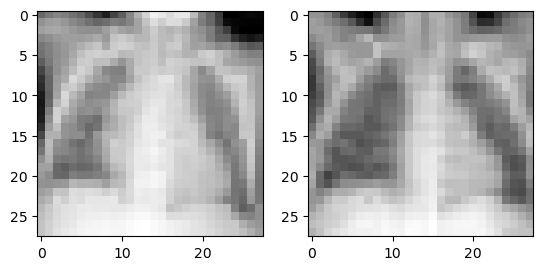

In [16]:
# Let's visually compare pneumial vs. healthy thoraic xray
# 0: normal, 1: pneumonia
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,2)
ax[0].imshow(train_array[0], cmap='gray') # pneumonia
ax[1].imshow(train_array[200],cmap='gray') # normal

The conversion has been successfully completed. Let us build a DC(CGAN), i.e., a conditional GAN, in order to be able to feed the labels as input into the generator and discriminator.

In [17]:
# Necessary packages
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy.random import randn
from numpy.random import randint
from keras.datasets.fashion_mnist import load_data
from keras.optimizers import Adam
from keras.models import Model,load_model
from keras.layers import Input, Dense, Reshape, Flatten, Conv2D, Conv2DTranspose, LeakyReLU, Dropout, Embedding, Concatenate

2023-04-13 11:11:45.704745: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


#### Discriminator architecture

In [20]:
# Define the standalone discriminator model
in_shape = (28,28,1)
n_classes = 2
# Label input
in_label = Input(shape=(1,))
# Embedding for categorical input
li = Embedding(n_classes, 50)(in_label)
# Scale up to image dimensions with linear activation
n_nodes = in_shape[0] * in_shape[1]
li = Dense(n_nodes)(li)
# Reshape to additional channel
li = Reshape((in_shape[0], in_shape[1], 1))(li)
# Image input
in_image = Input(shape=in_shape)
# Concat label as a channel
merge = Concatenate()([in_image, li])
# Downsample
fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(merge)
fe = LeakyReLU(alpha=0.2)(fe)
# Downsample
fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(fe)
fe = LeakyReLU(alpha=0.2)(fe)
# Flatten feature maps
fe = Flatten()(fe)
# Dropout
fe = Dropout(0.4)(fe)
# Output
out_layer = Dense(1, activation='sigmoid')(fe)
# Define model
discriminator = Model([in_image, in_label], out_layer)
discriminator.summary()
# Compile model
opt = Adam(learning_rate=0.0002, beta_1=0.5)
discriminator.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 1, 50)        100         ['input_5[0][0]']                
                                                                                                  
 dense_4 (Dense)                (None, 1, 784)       39984       ['embedding_2[0][0]']            
                                                                                                  
 input_6 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                            

#### Generator architecture

In [21]:
# Define the standalone generator model
latent_dim = 100
n_classes = 2

# Label input
in_label = Input(shape=(1,))

# Embedding for categorical input
li = Embedding(n_classes, 50)(in_label)

# Linear multiplication
n_nodes = 7 * 7
li = Dense(n_nodes)(li)

# Reshape to additional channel
li = Reshape((7, 7, 1))(li)

# Image generator input
in_lat = Input(shape=(latent_dim,))

# Foundation for 7x7 image
n_nodes = 128 * 7 * 7
gen = Dense(n_nodes)(in_lat)
gen = LeakyReLU(alpha=0.2)(gen)
gen = Reshape((7, 7, 128))(gen)

# Merge image gen and label input
merge = Concatenate()([gen, li])

# Upsample to 14x14
gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(merge)
gen = LeakyReLU(alpha=0.2)(gen)

# Upsample to 28x28
gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(gen)
gen = LeakyReLU(alpha=0.2)(gen)

# Output
out_layer = Conv2D(1, (7,7), activation='tanh', padding='same')(gen)

# Define model
generator = Model([in_lat, in_label], out_layer)
generator.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 input_7 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 dense_7 (Dense)                (None, 6272)         633472      ['input_8[0][0]']                
                                                                                                  
 embedding_3 (Embedding)        (None, 1, 50)        100         ['input_7[0][0]']                
                                                                                            

Notice that we have compiled the discriminator model but not the generator model. This is done on purpose. Now, we are going to build the GAN model, that combines both the generator model and the discriminator model into one larger model. This larger model will be used to train the model weights in the generator, using the output and error calculated by the discriminator model. The discriminator model is trained separately, and as such, the model weights are marked as not trainable in this larger GAN model to ensure that only the weights of the generator model are updated. 

In [22]:
# Define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
    
    # Make weights in the discriminator not trainable
    d_model.trainable = False
    
    # Get noise and label inputs from generator model
    gen_noise, gen_label = g_model.input
    
    # Get image output from the generator model
    gen_output = g_model.output
    
    # Connect image output and label input from generator as inputs to discriminator
    gan_output = d_model([gen_output, gen_label])
    
    # Define gan model as taking noise and label and outputting a classification
    model = Model([gen_noise, gen_label], gan_output)
    
    # Compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

We are ready to train our GAN. Firstly, let us prepare our data. We will require one batch (or a half) batch of real images from the dataset each update to the GAN model. A simple way to achieve this is to select a random sample of images from the dataset each time. I have implemented a function in order to deal with this problem, that, selects and returns a random sample of images and their corresponding class label for the discriminator,specifically class=1, indicating that they are real images.

In [23]:
# Select real samples
def generate_real_samples(dataset, n_samples):
    
    # Split into images and labels
    images, labels = dataset
    
    # Choose random instances
    ix = randint(0, images.shape[0], n_samples)
    
    # Select images and labels
    X, labels = images[ix], labels[ix]
    
    # Generate class labels
    y = ones((n_samples, 1))
    return [X, labels], y

Next, we need inputs for the generator model. These are random points from the latent space, specifically Gaussian distributed random variables.

In [24]:
# Generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=2):
    
    # Generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    
    # Reshape into a batch of inputs for the network
    z_input = x_input.reshape(n_samples, latent_dim)
    
    # Generate labels
    labels = randint(0, n_classes, n_samples)
    return [z_input, labels]

Before fit the GAN, we need to use the points in the latent space as input to the generator in order to generate new images. I have implemented a function in order to deal with this problem, that, generate points in the latent space and use them as input to the generator model. The function returns the generated images and their corresponding class label for the discriminator model, specifically class=0 to indicate they are fake or generated.

In [25]:
# Use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
    
    # Generate points in latent space
    z_input, labels_input = generate_latent_points(latent_dim, n_samples)
    
    # Predict outputs
    images = generator.predict([z_input, labels_input])
    
    # Create class labels
    y = zeros((n_samples, 1))
    return [images, labels_input], y

We are now ready to fit the GAN models. First, the discriminator model is updated for a half batch of real samples, then a half batch of fake samples, together forming one batch of weight updates. The generator is then updated via the composite gan model. Importantly, the class label is set to 1 or real for the fake samples. This has the effect of updating the generator toward getting better at generating real samples on the next batch. The generator model is saved at the end of training.

In [26]:
# Train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=128):
    
    bat_per_epo = int(dataset[0].shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    # Manually enumerate epochs
    for i in range(n_epochs):
        # Enumerate batches over the training set
        for j in range(bat_per_epo):
        
            # Get randomly selected 'real' samples
            [X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)
            # Update discriminator model weights
            d_loss1, _ = d_model.train_on_batch([X_real, labels_real], y_real)
            # Generate 'fake' examples
            [X_fake, labels], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            # Update discriminator model weights
            d_loss2, _ = d_model.train_on_batch([X_fake, labels], y_fake)
            # Prepare points in latent space as input for the generator
            [z_input, labels_input] = generate_latent_points(latent_dim, n_batch)
            # Create inverted labels for the fake samples
            y_gan = ones((n_batch, 1))
            # Update the generator via the discriminator's error
            g_loss = gan_model.train_on_batch([z_input, labels_input], y_gan)
        # Summarize loss on this batch
        print('>%d, d1=%.3f, d2=%.3f g=%.3f' %
        (i+1,  d_loss1, d_loss2, g_loss))
    # Save the generator model
    g_model.save('cgan_generator.h5')

#### Training the GAN

In [26]:
# Create the gan
gan_model = define_gan(generator, discriminator)
# Train model
train(generator, discriminator, gan_model, [train_array, label_train.reshape(4708)], latent_dim)

/opt/conda/lib/python3.7/site-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


2/2 [==============================] - 0s 5ms/step
>1, d1=0.315, d2=0.483 g=1.117
2/2 [==============================] - 0s 5ms/step
>2, d1=0.965, d2=0.659 g=0.860
2/2 [==============================] - 0s 5ms/step
>3, d1=0.876, d2=0.680 g=0.848
2/2 [==============================] - 0s 5ms/step
>4, d1=0.833, d2=0.658 g=0.811
2/2 [==============================] - 0s 5ms/step
>5, d1=0.684, d2=0.606 g=0.934
2/2 [==============================] - 0s 5ms/step
>6, d1=0.709, d2=0.712 g=0.771
2/2 [==============================] - 0s 6ms/step
>7, d1=0.674, d2=0.659 g=0.907
2/2 [==============================] - 0s 8ms/step
>8, d1=0.636, d2=0.604 g=0.922
2/2 [==============================] - 0s 5ms/step
>9, d1=0.660, d2=0.571 g=1.008
2/2 [==============================] - 0s 4ms/step
>10, d1=0.696, d2=0.551 g=0.873
2/2 [==============================] - 0s 5ms/step
>11, d1=0.679, d2=0.597 g=0.883
2/2 [==============================] - 0s 4ms/step
>12, d1=0.618, d2=0.661 g=0.830
2/2 [========

#### Synthetic Data Evaluation Metric

Given our hypothesis, we need to evaluate the GAN based on the downstream task i.e. the classification performance (AUC, ACC). However, we should also report a fidelity and diversity estimate of our synthetic data. This is not only useful as additional metric, but also as stopping criterion of GAN training (e.g., n epochs without improvement). We propose you use the [Fréchet Inception Distance](https://github.com/mseitzer/pytorch-fid), but feel free to suggest other or additional metrics. Feel free to use existing packages such as the [pytorch-fid](https://pypi.org/project/pytorch-fid/) package.

In [27]:
# Necessary imports
import numpy
from numpy import cov
from numpy import trace
from numpy import iscomplexobj
from numpy import asarray
from numpy.random import randint
from scipy.linalg import sqrtm
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.datasets.mnist import load_data
from skimage.transform import resize

**Explanation of Frechet Inception Distance**:

The Frechet Inception Distance, or FID for short, is a metric for evaluating the quality of generated images and specifically developed to evaluate the performance of GAN. The score was proposed as an improvement over the existing Inception Score, or IS.

The inception score estimates the quality of a collection of synthetic images based on how well the top-performing image classification model Inception v3 classifies them as one of 1,000 known objects. The scores combine both the confidence of the conditional class predictions for each synthetic image (quality) and the integral of the marginal probability of the predicted classes (diversity).

The inception score does not capture how synthetic images compare to real images. The goal in developing the FID score was to evaluate synthetic images based on the statistics of a collection of synthetic images compared to the statistics of a collection of real images from the target domain.

Like the inception score, the FID score uses the inception v3 model. Specifically, the coding layer of the model (the last pooling layer prior to the output classification of images) is used to capture computer-vision-specific features of an input image. These activations are calculated for a collection of real and generated images.

The activations are summarized as a multivariate Gaussian by calculating the mean and covariance of the images. These statistics are then calculated for the activations across the collection of real and generated images.

The distance between these two distributions is then calculated using the Frechet distance, also called the Wasserstein-2 distance.

A lower FID indicates better-quality images; conversely, a higher score indicates a lower-quality image and the relationship may be linear.

First, we can load the Inception v3 model in Keras directly, a pretrained model to calculate the activations or feature vectors for each image. This will prepare a version of the inception model for classifying images as one of 1,000 known classes.

In [28]:
# Load inception v3 model
model = InceptionV3(include_top=False, pooling='avg', input_shape=(299,299,3)) # Default shape

This model can then be used to predict the feature vector for one or more images. We need to reshape our images to use this pretrained model. I have implemented a function in order to do this.

In [29]:
# Scale an array of images to a new size
def scale_images(images, new_shape):
    images_list = list()
    for image in images:
        
        # Resize with nearest neighbor interpolation
        new_image = resize(image, new_shape, 0)
        
        # Store
        images_list.append(new_image)
    return asarray(images_list)

Now, I have implemented a function to compute FID, takes a collection of activations for real and generated images and return the FID score.

In [30]:
# Calculate frechet inception distance
def calculate_fid(model, images1, images2):
    # Calculate activations
    act1 = model.predict(images1)
    act2 = model.predict(images2)
   
    # Calculate mean and covariance statistics
    mu1, sigma1 = act1.mean(axis=0), cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), cov(act2, rowvar=False)
    
    # Calculate sum squared difference between means
    ssdiff = numpy.sum((mu1 - mu2)**2.0)
    
    # Calculate sqrt of product between cov
    covmean = sqrtm(sigma1.dot(sigma2))
    
    # Check and correct imaginary numbers from sqrt
    if iscomplexobj(covmean):
        covmean = covmean.real
    
    # Calculate score
    fid = ssdiff + trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

Let us compute the FID between the fake images generated by our GAN and the original ones.

In [31]:
# Load model
GAN_model = load_model('cgan_generator.h5')

# Generate images
latent_points, labels = generate_latent_points(100, 4708, 2)

# Specify labels
false_label = np.asarray([0 for x in range(2354)])
true_label = np.asarray([1 for x in range(2354)])
labels = np.concatenate((false_label, true_label),axis=0)
X  = GAN_model.predict([latent_points, labels])

148/148 [==============================] - 9s 60ms/step


Visualize how our model works!!
<a id='visualization'></a>

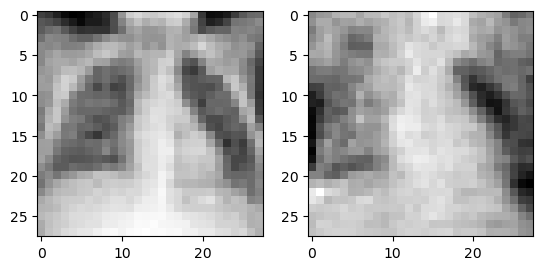

In [37]:
# Let's visually compare pneumial vs. healthy thoraic xray generated by our GAN
# 0: normal, 1: pneumonia
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,2)
ax[0].imshow(X[3], cmap='gray') # pneumonia
ax[1].imshow(X[2846],cmap='gray') # normal

In [34]:
# Compute FID
# Resize images
images1 = scale_images(X, (299,299,3))
images2 = scale_images(train_array, (299,299,3))

# Fid between images1 and images2
fid = calculate_fid(model,images1,images2)
print('FID: %.3f' % fid)

148/148 [==============================] - 461s 3s/step
FID: 64.905


# 6. Test of our GAN Method and Storage of Results

Now that you have trained your GAN, it is time for the big moment of testing our hypothesis. To do so, a balanced classifier training dataset (50% pneumonia, 50% normal) consisting only of synthetic data is suggested. You may sample this dataset from your trained conditional generator, store on disc and load it again here. 

In [38]:
# read data from disc (maybe also check dimensions)
generated_imgs_w_label_0 = X[:2354].reshape(X[:2354].shape[0],X[:2354].shape[3],X[:2354].shape[1],X[:2354].shape[2]) 
generated_imgs_w_label_1 = X[2354:].reshape(X[2354:].shape[0],X[2354:].shape[3],X[2354:].shape[1],X[2354:].shape[2]) 

Below some helper code to help define a torch CustomImageDataset Class based on the generated images that are loaded from disc.

In [39]:
from torch.utils.data import Dataset
import pandas as pd

class CustomImageDataset(Dataset):
    def __init__(self, imgs_label_0, imgs_label_1, transform=None, target_transform=None):
        self.img_labels = pd.DataFrame(
            np.concatenate((np.zeros(len(imgs_label_0), dtype=int),
                            np.ones(len(imgs_label_1), dtype=int)))
        )
        self.images = np.concatenate((imgs_label_0, imgs_label_1))
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        image = torch.from_numpy(self.images[idx])
        label = np.array([self.img_labels.iloc[idx, 0]])
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

Initialization of model, criterion and optimizer

In [40]:
from torch import optim

lr = 0.001

model_GAN = Net(in_channels=n_channels, num_classes=2)
    
# define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
    
optimizer = optim.SGD(model_GAN.parameters(), lr=lr, momentum=0.9)


In [41]:
# Create torch dataset with generated images 
train_gen_dataset = CustomImageDataset(generated_imgs_w_label_0, generated_imgs_w_label_1)
# Create torch dataloader 
train_gen_loader = DataLoader(dataset=train_gen_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_loader_at_eval = DataLoader(dataset=train_gen_dataset, batch_size=2*BATCH_SIZE, shuffle=False)

Training of the classifier, as was done above with real data, but now with the generated dataset (50% pneumonia, 50% normal).

In [42]:
from tqdm import tqdm
import torch
for epoch in range(NUM_EPOCHS):
    train_correct = 0
    train_total = 0
    test_correct = 0
    test_total = 0
    
    model_GAN.train()
    for inputs, targets in tqdm(train_gen_loader):
        # forward + backward + optimize
        optimizer.zero_grad()
        outputs = model_GAN(inputs)
        
        targets = targets.float()
        outputs = outputs.float()

        print(targets.shape)
        print(outputs.shape)
        loss = criterion(outputs, targets)
        
        loss.backward()
        optimizer.step()

  5%|██▍                                         | 2/37 [00:00<00:03,  9.76it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


 11%|████▊                                       | 4/37 [00:00<00:03,  9.74it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


 22%|█████████▌                                  | 8/37 [00:00<00:02, 10.73it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


 27%|███████████▌                               | 10/37 [00:00<00:02, 10.74it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


 38%|████████████████▎                          | 14/37 [00:01<00:02, 10.96it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


 43%|██████████████████▌                        | 16/37 [00:01<00:01, 11.09it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


 54%|███████████████████████▏                   | 20/37 [00:01<00:01, 11.01it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


 59%|█████████████████████████▌                 | 22/37 [00:02<00:01, 10.93it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


 70%|██████████████████████████████▏            | 26/37 [00:02<00:00, 11.02it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


 76%|████████████████████████████████▌          | 28/37 [00:02<00:00, 11.03it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


 86%|█████████████████████████████████████▏     | 32/37 [00:02<00:00, 11.06it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


 92%|███████████████████████████████████████▌   | 34/37 [00:03<00:00, 11.04it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


100%|███████████████████████████████████████████| 37/37 [00:03<00:00, 10.93it/s]


torch.Size([100, 1])
torch.Size([100, 1])


  0%|                                                    | 0/37 [00:00<?, ?it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


  5%|██▍                                         | 2/37 [00:00<00:03, 11.03it/s]

torch.Size([128, 1])
torch.Size([128, 1])


 11%|████▊                                       | 4/37 [00:00<00:02, 11.48it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


 16%|███████▏                                    | 6/37 [00:00<00:02, 11.15it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


 22%|█████████▌                                  | 8/37 [00:00<00:02, 11.42it/s]

torch.Size([128, 1])
torch.Size([128, 1])


 27%|███████████▌                               | 10/37 [00:00<00:02, 11.38it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


 32%|█████████████▉                             | 12/37 [00:01<00:02, 11.40it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


 38%|████████████████▎                          | 14/37 [00:01<00:02, 11.16it/s]

torch.Size([128, 1])
torch.Size([128, 1])


 43%|██████████████████▌                        | 16/37 [00:01<00:01, 11.17it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


 49%|████████████████████▉                      | 18/37 [00:01<00:01, 11.22it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


 54%|███████████████████████▏                   | 20/37 [00:01<00:01, 11.41it/s]

torch.Size([128, 1])
torch.Size([128, 1])


 59%|█████████████████████████▌                 | 22/37 [00:01<00:01, 11.64it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


 65%|███████████████████████████▉               | 24/37 [00:02<00:01, 11.59it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


 70%|██████████████████████████████▏            | 26/37 [00:02<00:00, 11.51it/s]

torch.Size([128, 1])
torch.Size([128, 1])


 76%|████████████████████████████████▌          | 28/37 [00:02<00:00, 11.28it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


 81%|██████████████████████████████████▊        | 30/37 [00:02<00:00, 11.19it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


 86%|█████████████████████████████████████▏     | 32/37 [00:02<00:00, 10.80it/s]

torch.Size([128, 1])
torch.Size([128, 1])


 92%|███████████████████████████████████████▌   | 34/37 [00:03<00:00, 10.73it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


100%|███████████████████████████████████████████| 37/37 [00:03<00:00, 11.23it/s]


torch.Size([100, 1])
torch.Size([100, 1])


  0%|                                                    | 0/37 [00:00<?, ?it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


  5%|██▍                                         | 2/37 [00:00<00:03, 10.82it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


 11%|████▊                                       | 4/37 [00:00<00:02, 11.06it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


 16%|███████▏                                    | 6/37 [00:00<00:02, 10.93it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


 22%|█████████▌                                  | 8/37 [00:00<00:02, 10.91it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


 27%|███████████▌                               | 10/37 [00:00<00:02, 11.25it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


 32%|█████████████▉                             | 12/37 [00:01<00:02, 11.32it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


 38%|████████████████▎                          | 14/37 [00:01<00:02, 11.15it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


 43%|██████████████████▌                        | 16/37 [00:01<00:01, 11.21it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


 49%|████████████████████▉                      | 18/37 [00:01<00:01, 10.97it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


 54%|███████████████████████▏                   | 20/37 [00:01<00:01, 10.99it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


 59%|█████████████████████████▌                 | 22/37 [00:01<00:01, 10.93it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


 65%|███████████████████████████▉               | 24/37 [00:02<00:01, 11.09it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


 70%|██████████████████████████████▏            | 26/37 [00:02<00:00, 11.11it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


 76%|████████████████████████████████▌          | 28/37 [00:02<00:00, 11.16it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


 81%|██████████████████████████████████▊        | 30/37 [00:02<00:00, 11.23it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


 86%|█████████████████████████████████████▏     | 32/37 [00:02<00:00, 11.27it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


 92%|███████████████████████████████████████▌   | 34/37 [00:03<00:00, 11.20it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


 97%|█████████████████████████████████████████▊ | 36/37 [00:03<00:00, 11.05it/s]

torch.Size([100, 1])
torch.Size([100, 1])


  0%|                                                    | 0/37 [00:00<?, ?it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


  5%|██▍                                         | 2/37 [00:00<00:03, 11.23it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


 11%|████▊                                       | 4/37 [00:00<00:03, 10.96it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


 16%|███████▏                                    | 6/37 [00:00<00:02, 11.12it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


 22%|█████████▌                                  | 8/37 [00:00<00:02, 11.01it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


 27%|███████████▌                               | 10/37 [00:00<00:02, 11.03it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


 32%|█████████████▉                             | 12/37 [00:01<00:02, 11.14it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


 38%|████████████████▎                          | 14/37 [00:01<00:02, 11.09it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


 43%|██████████████████▌                        | 16/37 [00:01<00:01, 11.29it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


 49%|████████████████████▉                      | 18/37 [00:01<00:01, 11.23it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


 54%|███████████████████████▏                   | 20/37 [00:01<00:01, 11.17it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


 59%|█████████████████████████▌                 | 22/37 [00:01<00:01, 11.10it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


 65%|███████████████████████████▉               | 24/37 [00:02<00:01, 11.00it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


 70%|██████████████████████████████▏            | 26/37 [00:02<00:00, 11.10it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


 76%|████████████████████████████████▌          | 28/37 [00:02<00:00, 11.15it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


 81%|██████████████████████████████████▊        | 30/37 [00:02<00:00, 11.30it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


 86%|█████████████████████████████████████▏     | 32/37 [00:02<00:00, 11.17it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


 92%|███████████████████████████████████████▌   | 34/37 [00:03<00:00, 11.21it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


 97%|█████████████████████████████████████████▊ | 36/37 [00:03<00:00, 11.20it/s]

torch.Size([100, 1])
torch.Size([100, 1])


  0%|                                                    | 0/37 [00:00<?, ?it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


  5%|██▍                                         | 2/37 [00:00<00:03, 10.94it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


 11%|████▊                                       | 4/37 [00:00<00:02, 11.18it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


 16%|███████▏                                    | 6/37 [00:00<00:02, 11.19it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


 22%|█████████▌                                  | 8/37 [00:00<00:02, 11.21it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


 27%|███████████▌                               | 10/37 [00:00<00:02, 11.32it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


 32%|█████████████▉                             | 12/37 [00:01<00:02, 11.24it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


 38%|████████████████▎                          | 14/37 [00:01<00:02, 11.26it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


 43%|██████████████████▌                        | 16/37 [00:01<00:01, 11.17it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


 49%|████████████████████▉                      | 18/37 [00:01<00:01, 11.18it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


 54%|███████████████████████▏                   | 20/37 [00:01<00:01, 11.11it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


 59%|█████████████████████████▌                 | 22/37 [00:01<00:01, 11.10it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


 65%|███████████████████████████▉               | 24/37 [00:02<00:01, 11.06it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


 70%|██████████████████████████████▏            | 26/37 [00:02<00:00, 11.06it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


 76%|████████████████████████████████▌          | 28/37 [00:02<00:00, 11.05it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


 81%|██████████████████████████████████▊        | 30/37 [00:02<00:00, 11.08it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


 86%|█████████████████████████████████████▏     | 32/37 [00:02<00:00, 11.02it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


 92%|███████████████████████████████████████▌   | 34/37 [00:03<00:00, 11.13it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


 97%|█████████████████████████████████████████▊ | 36/37 [00:03<00:00, 11.14it/s]

torch.Size([100, 1])
torch.Size([100, 1])


100%|███████████████████████████████████████████| 37/37 [00:03<00:00, 11.18it/s]


Test of the classifier, as was done above with real data, but now with the generated dataset.

In [43]:
print('==> Evaluating GAN model ...')
acc_train_GAN, auc_train_GAN, y_true, cm_train_GAN, fpr_train_GAN, tpr_train_GAN = test('train', model_GAN)
acc_val_GAN, auc_val_GAN, y_true, cm_val_GAN, fpr_val_GAN, tpr_val_GAN = test('val', model_GAN)
acc_test_GAN, auc_test_GAN, y_true, cm_test_GAN, fpr_test_GAN, tpr_test_GAN = test('test', model_GAN)

==> Evaluating GAN model ...
train  auc: 1.000  acc:1.000
val  auc: 0.964  acc:0.918
test  auc: 0.934  acc:0.864


# 7. Comparison of our Method and Baseline, Interpretration of Results

You may use some visualization techniques here to compare the baseline (i) with your method (ii). For example, it would be interesting to plot both ROC-AUC curves to visually compare them. Another visualization option is a confusion matrix for (i) and (ii).

In [68]:
# example function for plotting multiple ROC-AUC curve in one figure.
def plot_roc_cur(fpr1, tpr1, fpr2, tpr2, auc1, auc2):  
    plt.plot(fpr1, tpr1, color='orange', label='Classifier 1 (AUROC = %0.3f)' % auc1)
    plt.plot(fpr2, tpr2, color='Lightblue', label='Classifier 2 (AUROC = %0.3f)' % auc2)
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

First, let us create a table comparing the values (auc and acc) of our method and baseline.

|              | Baseline model (auc/acc) | | GAN model (auc/acc) | |
|--------------|-------------------------|-|---------------------|-|
| Train        | 0.990 / 0.957           | | 1.000 / 1.000       | |
| Validation   | 0.988 / 0.958           | | 0.964 / 0.918       | |
| Test         | 0.944 / 0.830           | | 0.934 / 0.864       | |


Notice that we have a really similar performance! Let us check the confusion matrix and the ROC-AUC curve for the validation set on both models, in the train, validation and test set.
<a id='trainingstudy'></a>

## Train set

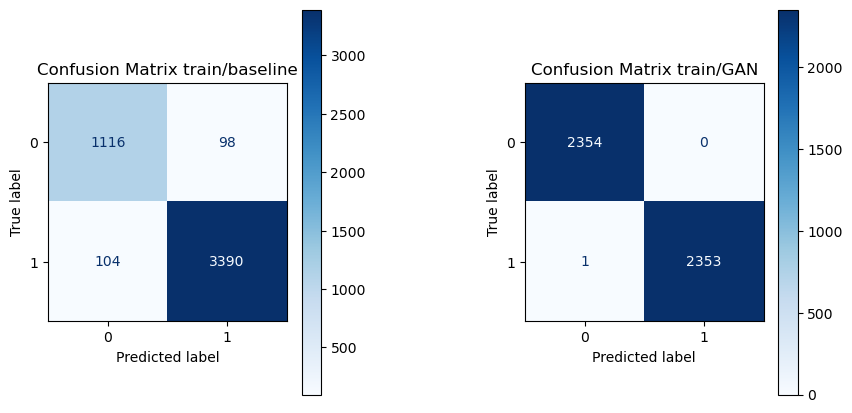

In [78]:
# Confusion matrices 

# Create a figure with two subplots side by side
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first subplot on the left
disp1 = ConfusionMatrixDisplay(confusion_matrix=cm_train_baseline)
disp1.plot(ax=ax[0], values_format='.0f', cmap='Blues')

# Plot the second subplot on the right
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm_train_GAN)
disp2.plot(ax=ax[1], values_format='.0f', cmap='Blues')

# Custom image 
ax[0].set_title('Confusion Matrix train/baseline')
ax[1].set_title('Confusion Matrix train/GAN')

# adjust spacing between subplots
plt.subplots_adjust(wspace=0.6)

# show the plot
plt.show()

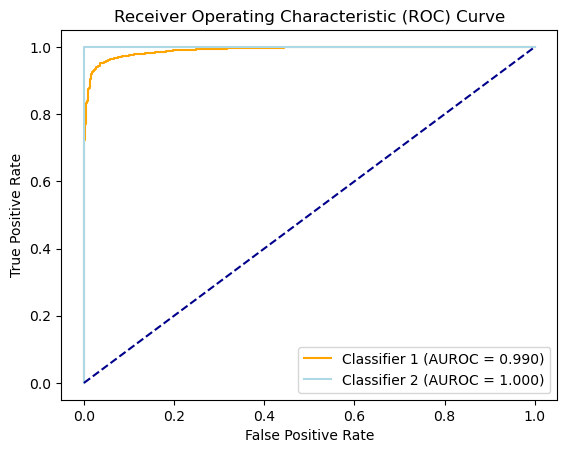

In [69]:
#ROC-AUC curve
plot_roc_cur(fpr_train_baseline, tpr_train_baseline,
             fpr_train_GAN, tpr_train_GAN, auc_train_baseline, auc_train_GAN)
# CLASSIFIER 1 --> BASELINE
# CLASSIFIER 2 --> GAN

## Validation set

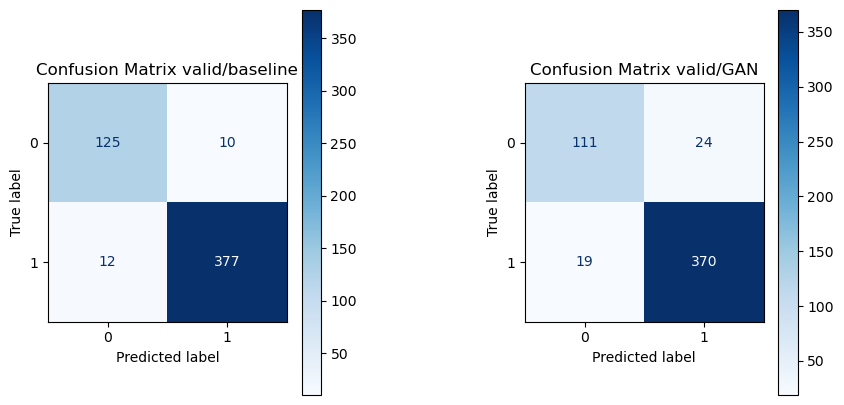

In [77]:
# Confusion matrices 

# Create a figure with two subplots side by side
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first subplot on the left
disp1 = ConfusionMatrixDisplay(confusion_matrix=cm_val_baseline)
disp1.plot(ax=ax[0], values_format='.0f', cmap='Blues')

# Plot the second subplot on the right
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm_val_GAN)
disp2.plot(ax=ax[1], values_format='.0f', cmap='Blues')

# Custom image 
ax[0].set_title('Confusion Matrix valid/baseline')
ax[1].set_title('Confusion Matrix valid/GAN')

# adjust spacing between subplots
plt.subplots_adjust(wspace=0.6)

# show the plot
plt.show()

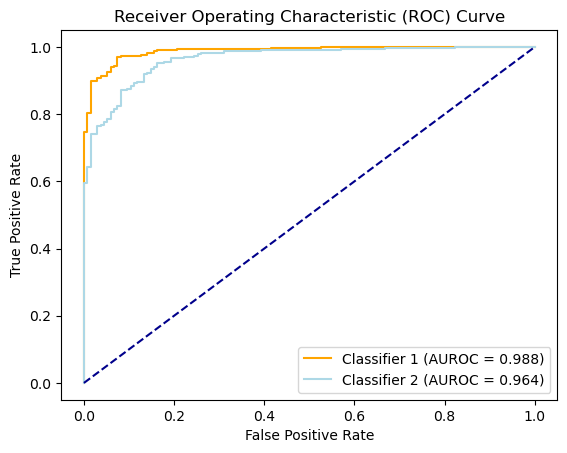

In [73]:
# ROC-AUC curve
plot_roc_cur(fpr_val_baseline, tpr_val_baseline,
             fpr_val_GAN, tpr_val_GAN, auc_val_baseline, auc_val_GAN)
# CLASSIFIER 1 --> BASELINE
# CLASSIFIER 2 --> GAN

## Test set

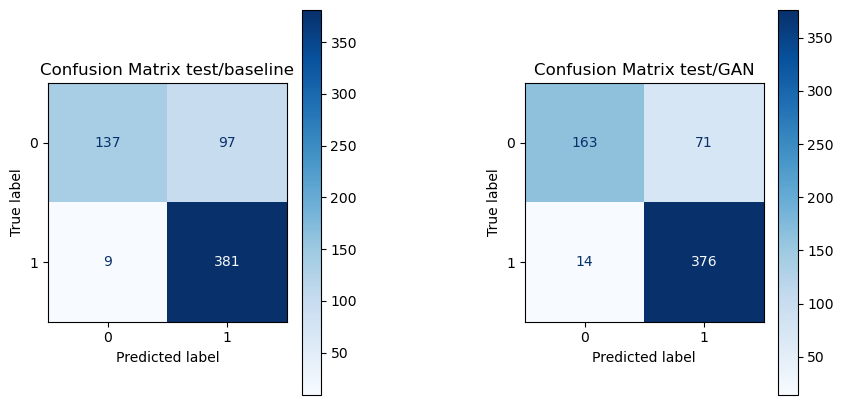

In [76]:
# Confusion matrices 

# Create a figure with two subplots side by side
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first subplot on the left
disp1 = ConfusionMatrixDisplay(confusion_matrix=cm_test_baseline)
disp1.plot(ax=ax[0], values_format='.0f', cmap='Blues')

# Plot the second subplot on the right
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm_test_GAN)
disp2.plot(ax=ax[1], values_format='.0f', cmap='Blues')

# Custom image 
ax[0].set_title('Confusion Matrix test/baseline')
ax[1].set_title('Confusion Matrix test/GAN')

# adjust spacing between subplots
plt.subplots_adjust(wspace=0.6)

# show the plot
plt.show()

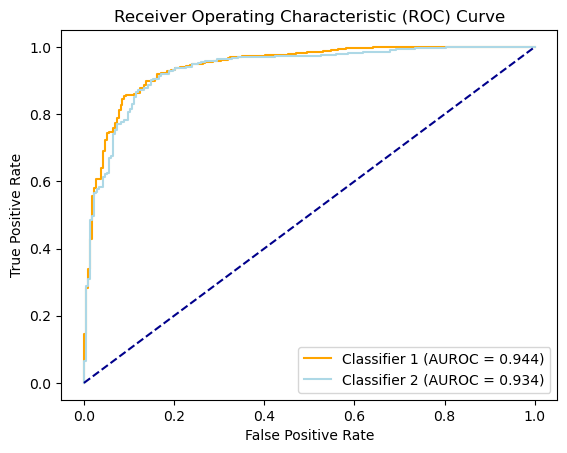

In [75]:
# ROC-AUC curve
plot_roc_cur(fpr_test_baseline, tpr_test_baseline,
             fpr_test_GAN, tpr_test_GAN, auc_test_baseline, auc_test_GAN)
# CLASSIFIER 1 --> BASELINE
# CLASSIFIER 2 --> GAN

How would you interpret the results you achieved? Would you say your GAN-based privatization method is useful in practice? Do you reject or accept the hypothesis defined above?

> Notice that in the training set, the classifier trained with the generated images works almost perfect, only one mistake, while the classifier trained with the real images works much worse, obtaining more than 200 errors. Nevertheless, this does not mean anything. Our classifier is trained with a **balanced dataset** while the baseline is trained with an unbalanced dataset (75%/25%), thus, it was to be expected that the baseline would not make a perfect classification in the train. At this point, we can already observe a first advantage of training with GAN images, we can balanced a dataset, and, if the image are quite similar to the real ones, we have balanced a dataset "for free".

> Let us continue with the analysis. Observing the ROC-AUC curves and the confusion matrices of the validation and test set, we can perceive a really similar performance. However, the baseline classifier performs slighlty better than the GAN classifier. A possible problem we are getting in this particular case is overfitting. We should analyse the learning curves but we are most likely causing overfitting.

> Therefore, in my opinion, I would say that my GAN-based privatization method is useful in practice. We have a really similar performance with synthetic images!! That is very powerful, we do not need to collect more data to create our ML models, and, since there are many problems regarding privacy issues in the health word, that is really useful.

> Let us remember the hypothesis we made at the beginning: Could we, instead of using real patient data, use only synthetic data to train our classifier and achieve comparable performance? The answer is clearly yes, we have achieved a comparable performance with synthetic data, hence, we accept the hypothesis!

# 8. Reflective Account

What could be the reasons why our study did or did not succeed? What do you think are the limitations of our study? What can we learn and takeaway from this exercise? How should it inform our future work? What would you try next?

> From my point of view, one of the reasons for the success of our model is the way we have trained it, i.e., we have trained our model with a balanced dataset, instead of the real one, which was unbalanced(75%/25%). This is a great advantage for our model to identify the minority class more quickly and is immediately reflected in the [previous study of the training set](#trainingstudy). Maybe, another reason for success could be the type of images that we have. Our problem, does not appear to be very complicated and it does not seem very difficult to distinguish normal images from images with pneumonia, and this makes the GAN capable with only the 4708 images we have, to imitate the dataset. Actually, a general problem with GANs is that they are very difficult to train and require a large amount of data, which is not the case here because of the seemingly simple problem to be solved. In fact, if we [visualize the images generated by our GAN](#visualization), we can observe the quality of the imitation. It is enough for our classification but, some of them, are not super realistic, which would lead to problems for a classification if we needed detailed information.

> I believe that, as I have said, we are limitated to our problem, i.e., if we wanted to get more detailed information from the synthetic images, or to classify another, perhaps more complicated, type of disease, it would be a problem would be a problem considering the quality of the images.

> The takeaway from this exercise, or what I have learnt, is that GANs can be very powerful in some problems. Given all the problems of data privatisation that exist in the world of health, I think it is essential to be able to do this data augmentation in an effective way. I also find it a very powerful tool in unbalanced datasets, as we can oversample the minority class to improve the performance of our classifier.

> For future work, I would propose to improve the architecture of the created GAN, as well as, to do some hyperparameter tuning with the latent dimension and the dimensions of the embeddings.

Thank you for working on this study. We hope you enjoyed it and it was a good learning experience for you.

Please send any feedback you may have to [Richard.Osuala@ub.edu](mailto:Richard.Osuala@ub.edu).